# TP Random Forest - XGBoost

This practical session will allow you to apprehend two very popular ensemble classification methods.
1. Random Forest
2. XGBoost

It is structured as follows
1. The challenge
2. Decision Tree
3. Random Forest
4. XGBoost
5. Analysis

## The challenge
### Introduction
ESA's new Earth Observation constellation **Sentinel-2** provides images with high spatial resolution (10m), with many spectral bands, and a short revisit time of 5 days. It produces time series (in other words, a video) of multispectral images, over all continental surfaces in the world. One of the many practical applications of this imagery, is Land Cover mapping, which involves classifying the various objects that can be seen from a satellite : roads, forests, cities, fields, etc. This is a real supervised classification problem, which is used by several industrials, but also in the public domain (by the C.N.E.S. for instance). The idea is to use an entire year of data to classify each pixel. The temporal information is very useful for distinguishing between different crop types, and to mitigate the negative impact of clouds. There are a few reasons why this problem is challenging. First of all, the very large dimension of the multi-spectral time series : each time series is composed of 33 dates spread across the year, and each date is an image with 10 spectral bands. Therefore, the base feature space is already 330 dimensions. Secondly, there is a great amount of intra-class variation, due to the variety of cultural practices and climatic differences between different areas. Finally, the class nomenclature itself is quite challenging. In this session you will be working with a reduced nomenclature, with only 8 classes, but the full target nomenclature contains 17 classes.

In this practial session, you will test a few basic classification methods to try to solve this problem.
### The data set
The data set is composed of two different areas, a train area, and a test area. For each area, two files have been given.
- The time series : **train1.npy / test1.npy** 
- The labels of some of the pixels in the images **train1ref.npy / train1ref_s.npy / test1ref.npy**

**train1ref_s.npy** is a reduced version of **train1ref.npy**, with fewer samples per class for a faster training.

Q1. Import the training image in a numpy array using *np.load*. Look at the dimension of the image.

In [30]:
#Solution
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as disp
data=np.load("train1.npy")[0:1000,0:1000,:]
datasize=data.shape
print(datasize)

(1000L, 1000L, 330L)


The time series is organized first per date, and for each date, the spectral bands are organized as follows. 
- Visible
    - B1 (490 nm) (Blue)
    - B2 (560 nm) (Green)
    - B3 (665 nm) (Red)
- Near Infra Red
    - B4 (842 nm) (NIR, 10m)
    - B5 (705 nm)
    - B6 (740 nm)
    - B7 (783 nm)
    - B8 (865 nm)
- Short wave IR
    - B9 (1610 nm)
    - B10(2190 nm)
    
Q2. Use the function *displayImage* to visualize the RGB bands of the first date. Try to understand the normalize function, and why it is necessary.

In [31]:
def normalize(i,vmax=50):
    return i*255/vmax if i < vmax else 255

def displayImage(data):
    normalize_v=np.vectorize(normalize)
    data_norm=normalize_v(data).astype(np.uint8)
    disp.display(plt.imshow(data_norm))

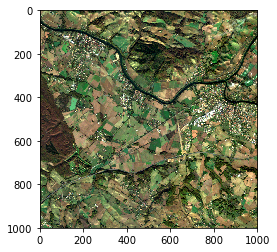

In [32]:
#Solution
displayImage(data[:,:,np.array([2,1,0])])

Q3. Show the 20th date in false color, by replacing the red band by the infra-red band (B4)

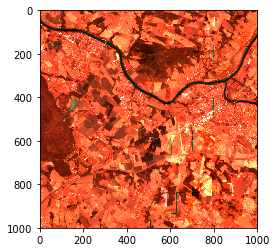

In [33]:
#Solution
displayImage(data[:,:,np.array([203,201,200])])

Q4. Import the reduced set of training labels *train1ref_s.npy*, and visualize them using *displayMap*.

In [34]:
from matplotlib import colors
def displayMap(m):
    cmap = colors.ListedColormap(['white','#f05824','#f8f381','#1b9c4a','#afd037','#53a97f','#a13a94','#b7529e','#dba0c8','#f0cee2','#3a54a3','#a9a937','#6eccdc','#511616'])
    bounds=[0,11,12,31,34,36,41,42,43,44,51,211,221,222,223]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    plt.imshow(m,cmap=cmap,norm=norm)
    plt.colorbar(cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)
    plt.show()

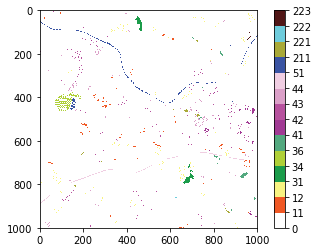

In [35]:
#Solution
refdata=np.load("train1ref_s.npy")[0:1000,0:1000,0]  
displayMap(refdata)

The class nomenclature is as follows

- 0 : Unknown
- 11 : Summer crop
- 12 : Winter crop
- 31 : Forest
- 34 : Natural grassland
- 36 : Woody moorlands
- 41 : Continuous urban fabric
- 42 : Discontinuous urban fabric
- 43 : Industrial and commercial units
- 44 : Roads
- 51 : Water
- 211 : Intensive grasslands

The final objective will be to label all of the pixels that are labeled "0", meaning the pixels where we do not yet know the class. For this, we're going to learn a classification model. The goal of this model is to associate a label to an unlabeld sample, or in this case, an unlabeled pixel. To train the model, we will have to start by adapting the data set to a format thats readable by scikit-learn, i.e. a list of samples (data) and a list of labels (target).

Q5. Create two identically sized lists, containing respectively the data samples, and their associated labels. For this, you can loop on the X and Y indices of the image, check if the point is labeled, and if it is, append it to your list. How many training samples are available ? How many are available per class (hint : use *plotPriors*) ?

In [36]:
def plotPriors(targetList):
    bins=[11,12,31,34,36,41,42,43,44,51,211,221,222,223]
    priors=np.histogram(targetList, bins)[0]
    plt.bar(np.arange(1,len(priors)+1), priors)
    ax=plt.gca()
    ax.set_xticklabels(bins[:-1])
    ax.set_xticks(np.arange(1,len(priors)+1))
    plt.show()

24503


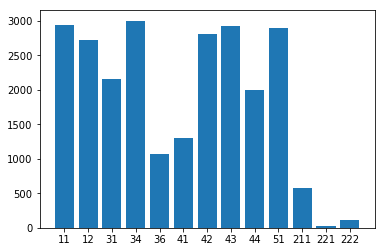

In [37]:
#Solution
def imToLists(data,ref):
    datalist=[]
    targets=[]
    datasize=data.shape
    for x in range(0,datasize[0]):
        for y in range (0,datasize[1]):
            if ref[x,y] > 0 :
                datalist.append(data[x,y])
                targets.append(ref[x,y])
    return datalist, targets
trd, trt = imToLists(data,refdata)
print(len(trd))
plotPriors(trt)

Q6. In the same way as in previous questions, prepare a list of validation data samples, and a list of their validation labels, using the validation datasets **test1.npy** and **test1ref.npy**. Why is the same image not used for both training and validation ?

In [40]:
#Solution
data_v = np.load("test1.npy")[0:1000,0:1000,:]
datasize_v=data_v.shape
print(datasize_v)
refdata_v = np.load("test1ref.npy")[0:1000,0:1000,0]
ted, tet = imToLists(data_v,refdata_v)
#To avoid correlation between training and testing data sets, by similar pixels coming from the same city, field, etc.

(1000L, 1000L, 330L)


## Decision Tree
Q7. Train a decision tree on the training data, and 
1. Print the training error.
2. Print the confusion matrix, using the confusion_matrix function from sklearn.metrics
3. Show the feature importance (use the feature\_importances\_ attribute of the classifier). You can reorganize them into a 33x10 matrix using *reshape*, and plot them with *imshow*. 

Training error: 0.104916
[[535  14   9   0   4   0]
 [  3 250   0   1  44   1]
 [  0   3  77   2  13   0]
 [  2   1   0  22  23   0]
 [  0  15   0   0 577   2]
 [  0   2   0   0  36  32]]


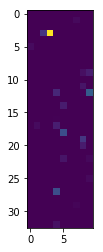

In [10]:
#Solution
from sklearn import tree
from sklearn.metrics import confusion_matrix
def evalDT(train_data, train_targets, test_data, test_targets, max_depth=5):
    dt = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=max_depth)
    dt.fit(train_data,train_targets)
    return dt, dt.score(train_data,train_targets), dt.score(test_data,test_targets)
dt, dtTrainScore, dtGenScore = evalDT(trd,trt,ted,tet,5)
print("Training error: %g"%(1-dtTrainScore))
print(confusion_matrix(trt, dt.predict(trd)))
disp.display(plt.imshow(dt.feature_importances_.reshape(33,10)))

Q7. Classify the whole image that was used for training. For this, you can use the *predict* method of the classifier. It allows you to classify an batch of samples, by providing it with a np.array of those samples. You can loop on the columns of the image, and classify each column with one call of *predict*.

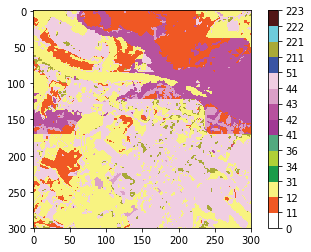

In [11]:
#Solution
def classifyImage(image,model): 
    datasize=image.shape
    #Initialisation de la sortie
    pred=np.zeros((datasize[0],datasize[1]))
    #Boucle sur les colonnes
    for x in range(0,datasize[0]):
        #Predict prend la colonne entière et sort toutes les étiquettes
        pred[x,:]=model.predict(image[x,:,:])
    return pred
pred=classifyImage(data,dt)
displayMap(pred)

Q8. Now look at the generalization error, and the confusion matrix, using the validation data set. What are the main sources of confusion ? How does this classifier perform ?

In [12]:
#Solution
print("Generalization error: %g"%(1-dt.score(ted,tet)))
print(confusion_matrix(tet, dt.predict(ted)))

Generalization error: 0.756671
[[  67  382 1053    0    0    0    0]
 [   0  876 1686   11  210    0    1]
 [  23   57  494    0  166    0  193]
 [  49    5  365    2   31    0   51]
 [   0    0    0    0    0    0    0]
 [   1   84    0    0    0    0    0]
 [   0   10  142    0   17    0   20]]


Q9. Classify the validation image, and visually analyze the result, by comparing it to the RGB bands of the first date of the image.

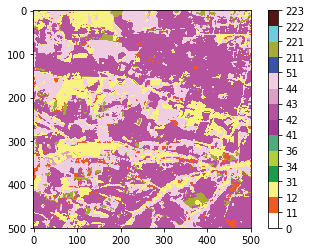

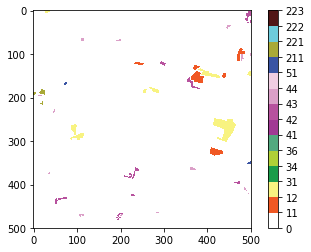

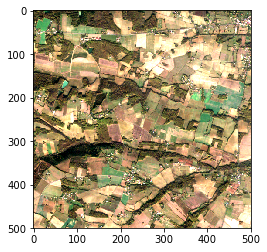

In [13]:
#Solution
predImage_v=classifyImage(data_v,dt)
displayMap(predImage_v)
displayMap(refdata_v)
displayImage(data_v[:,:,np.array([2,1,0])])

## Random Forest

Now, we are going to use a group of trees (often called an ensemble), to try to improve the precision of the classification. The main parameters are :
- n_estimators : The number of trees
- criterion : The split criterion
- max_depth : The maximal depth of the trees
- max_features : The maximum amount of features tested at each split

The complete list can be found here :
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Q10. Repeat the steps of questions 6 to 9, using the Random Forest classifier, with a max depth of 5, and 10 trees.

Training error: 0
Generalization error: 0.52018


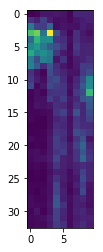

[[  67  382 1053    0    0    0    0]
 [   0  876 1686   11  210    0    1]
 [  23   57  494    0  166    0  193]
 [  49    5  365    2   31    0   51]
 [   0    0    0    0    0    0    0]
 [   1   84    0    0    0    0    0]
 [   0   10  142    0   17    0   20]]


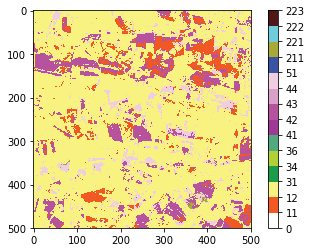

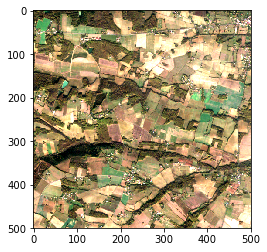

In [14]:
#Solution
from sklearn import ensemble

def evalRF(train_data, train_targets, test_data, test_targets, n_estimators=10, max_depth=5):
    rf = ensemble.RandomForestClassifier(criterion = 'entropy',n_estimators=n_estimators,max_depth=max_depth)
    rf.fit(train_data,train_targets)
    return rf, rf.score(train_data,train_targets), rf.score(test_data,test_targets)
rf, rfTrainScore, rfGenScore = evalRF(trd,trt,ted,tet,200,20)
print("Training error: %g"%(1-rfTrainScore))
print("Generalization error: %g"%(1-rfGenScore))
plt.imshow(rf.feature_importances_.reshape(33,10))
plt.show()
print(confusion_matrix(tet, dt.predict(ted)))
predImage_v=classifyImage(data_v,rf)
displayMap(predImage_v)
displayImage(data_v[:,:,np.array([2,1,0])])

## XGBoost

Q11. Repeat the steps of questions 6-9 with the XG-boost classifier, with 10 trees.

Training error: 0.029976
Generalization error: 0.724817


[[680 604 218   0   0   0   0]
 [515 906  21   0 619   0 723]
 [ 50 767  63   5  48   0   0]
 [ 93 295 103   1   9   0   2]
 [  0   0   0   0   0   0   0]
 [  0  42  39   0   4   0   0]
 [  0 186   0   0   3   0   0]]


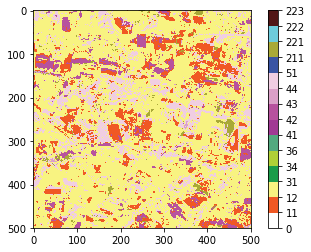

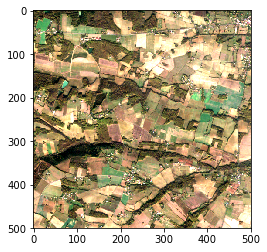

In [15]:
#Solution
from sklearn.ensemble import GradientBoostingClassifier

def evalXGB(train_data, train_targets, test_data, test_targets, n_estimators=10, max_depth=5):
    gtb = GradientBoostingClassifier(n_estimators=n_estimators,max_depth=max_depth)
    gtb.fit(train_data,train_targets)
    return gtb, gtb.score(train_data,train_targets), gtb.score(test_data,test_targets)
gtb, trainScore, genScore = evalXGB(trd,trt,ted,tet,10,5)
print("Training error: %g"%(1-trainScore))
print("Generalization error: %g"%(1-genScore))
disp.display(plt.imshow(gtb.feature_importances_.reshape(33,10)))
print(confusion_matrix(tet, gtb.predict(ted)))
predImage_v=classifyImage(data_v,gtb)
displayMap(predImage_v)
displayImage(data_v[:,:,np.array([2,1,0])])

## Questions
Q12. Analyze the effect of the depth of the trees used by the classifier, using both the training error and the generalization errors, for the DT, RF and XGB. For the last two, use a fixed low number of estimators (10 for example). In which case is there overfitting ? How do the ensemble classifiers counter overfitting ?

Q13. For the Random Forest and XGBoost classifiers : Analyse the impact of the number of trees on the training error and on the generalization error. In which case is there overfitting ? 

Q14. Add 100 features of noise to the image, using *np.random.rand* and *np.concatenate*. What is the impact on the different classification results ? Compare a case with few trees, and a case with many trees, and explain the results.

Q15. Copy the first feature  of the image 100 times, and add it to the original image. What is the impact on the different classifiers ? Compare a case with few trees, and a case with many trees, and explain the results.

Q16. Multiply the first 100 features by a constant factor of 1000. What is the impact on the different classifiers ?

Q17. The Normalized Differential Vegetation Index (NDVI) is a non linear combination of Red and Infrared bands that reacts strongly to vegetation, due to the Red-Edge effect. Create the stack of NDVI, using the formula given below, and add it to the classification. How do the classifiers react ? 
$$ NDVI=\frac{IR-R}{IR+R}$$

Q18. Use your best classifier, parameters, and features, to train using the full training set **train1ref.npy**, and to classify the validation image. 

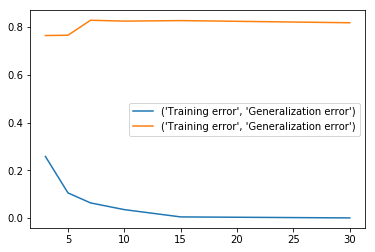

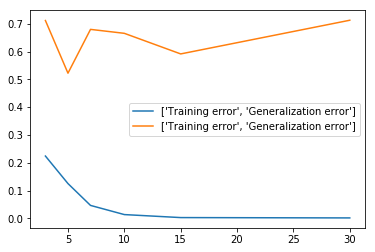

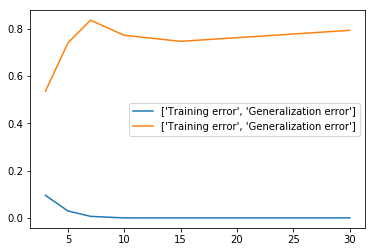

In [16]:
#Solution Q12
depths=[3,5,7,10,15,30]
dtResults=[]
rfResults=[]
gtbResults=[]
for d in depths:
    dt, dtTrainScore, dtGenScore = evalDT(trd,trt,ted,tet,d)
    dtResults.append([dtTrainScore, dtGenScore])
    rf, rfTrainScore, rfGenScore = evalRF(trd,trt,ted,tet,10,d)
    rfResults.append([rfTrainScore, rfGenScore])
    gtb, gtbTrainScore, gtbGenScore = evalXGB(trd,trt,ted,tet,10,d)
    gtbResults.append([gtbTrainScore, gtbGenScore])
    
plt.plot(depths,1-np.array(dtResults),label=('Training error', 'Generalization error'))
plt.legend()
plt.show()
plt.plot(depths,1-np.array(rfResults),label=['Training error', 'Generalization error'])
plt.legend()
plt.show()
plt.plot(depths,1-np.array(gtbResults),label=['Training error', 'Generalization error'])
plt.legend()
plt.show()

In [17]:
#Q13
nTrees=[5,10,20,50,100]
dtResults=[]
rfResults=[]
gtbResults=[]
for n in nTrees:
    rf, rfTrainScore, rfGenScore = evalRF(trd,trt,ted,tet,n,5)
    rfResults.append([rfTrainScore, rfGenScore])
    gtb, gtbTrainScore, gtbGenScore = evalXGB(trd,trt,ted,tet,n,5)
    gtbResults.append([gtbTrainScore, gtbGenScore])

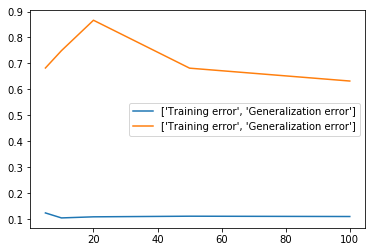

In [18]:
plt.plot(nTrees,1-np.array(rfResults),label=['Training error', 'Generalization error'])
plt.legend()
plt.show()

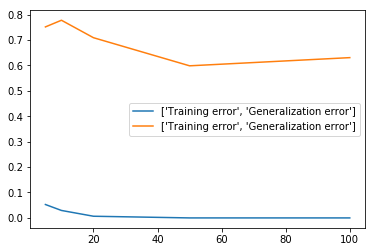

In [19]:
plt.plot(nTrees,1-np.array(gtbResults),label=['Training error', 'Generalization error'])
plt.legend()
plt.show()

In [20]:
#Q14
data_noise=np.concatenate((data,np.random.rand(datasize[0],datasize[1],100)),axis=2)
trd, trt = imToLists(data_noise,refdata)
print(len(trd[0]))

430


In [21]:
data_v_noise=np.concatenate((data_v,np.random.rand(datasize_v[0],datasize_v[1],100)),axis=2)
ted, tet = imToLists(data_v_noise,refdata_v)
print(len(ted[0]))

430


In [22]:
dt, dtTrainScore, dtGenScore = evalDT(trd,trt,ted,tet,5)
rf, rfTrainScore, rfGenScore = evalRF(trd,trt,ted,tet,100,5)
gtb, gtbTrainScore, gtbGenScore = evalXGB(trd,trt,ted,tet,10,5)

In [23]:
print("Training error: %g"%(1-dtTrainScore))
print("Generalization error: %g"%(1-dtGenScore))
print("Training error: %g"%(1-rfTrainScore))
print("Generalization error: %g"%(1-rfGenScore))
print("Training error: %g"%(1-gtbTrainScore))
print("Generalization error: %g"%(1-gtbGenScore))

Training error: 0.104916
Generalization error: 0.704136
Training error: 0.114508
Generalization error: 0.56054
Training error: 0.029976
Generalization error: 0.691461


In [24]:
#Q15
data_c=np.zeros((datasize[0],datasize[1],100))
for i in range(0,100):
    data_c[:,:,i]=data[:,:,0]
data_copy=np.concatenate((data,data_c),axis=2)

data_c=np.zeros((datasize_v[0],datasize_v[1],100))
for i in range(0,100):
    data_c[:,:,i]=data_v[:,:,0]
data_v_copy=np.concatenate((data_v,data_c),axis=2)

trd, trt = imToLists(data_copy,refdata)
ted, tet = imToLists(data_v_copy,refdata_v)

dt, dtTrainScore, dtGenScore = evalDT(trd,trt,ted,tet,5)
rf, rfTrainScore, rfGenScore = evalRF(trd,trt,ted,tet,10,5)
gtb, gtbTrainScore, gtbGenScore = evalXGB(trd,trt,ted,tet,10,5)

print("Training error: %g"%(1-dtTrainScore))
print("Generalization error: %g"%(1-dtGenScore))
print("Training error: %g"%(1-rfTrainScore))
print("Generalization error: %g"%(1-rfGenScore))
print("Training error: %g"%(1-gtbTrainScore))
print("Generalization error: %g"%(1-gtbGenScore))

Training error: 0.104916
Generalization error: 0.718312
Training error: 0.109712
Generalization error: 0.756504
Training error: 0.0293765
Generalization error: 0.809373


In [25]:
#Q16
data_p=data
data_v_p=data_v
for i in range(0,100):
    data_p[:,:,i]*=1000
    data_v_p[:,:,i]*=1000

trd, trt = imToLists(data_p,refdata)
ted, tet = imToLists(data_v_p,refdata_v)

dt, dtTrainScore, dtGenScore = evalDT(trd,trt,ted,tet,5)
rf, rfTrainScore, rfGenScore = evalRF(trd,trt,ted,tet,10,5)
gtb, gtbTrainScore, gtbGenScore = evalXGB(trd,trt,ted,tet,10,5)

print("Training error: %g"%(1-dtTrainScore))
print("Generalization error: %g"%(1-dtGenScore))
print("Training error: %g"%(1-rfTrainScore))
print("Generalization error: %g"%(1-rfGenScore))
print("Training error: %g"%(1-gtbTrainScore))
print("Generalization error: %g"%(1-gtbGenScore))

Training error: 0.130695
Generalization error: 0.424283
Training error: 0.116307
Generalization error: 0.608572
Training error: 0.029976
Generalization error: 0.533356


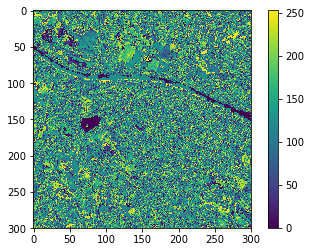

In [27]:
ndvi=np.zeros((datasize[0],datasize[1],33)).astype(float)
for i in range(0,33):
    ir=data[:,:,i+6].astype(float)
    r=data[:,:,i+2].astype(float)
    ndvi[:,:,i]=(((ir-r)/(ir+r+0.01))*127+127).astype(np.uint8)
plt.imshow(ndvi[:,:,0])
plt.colorbar()
plt.show()
ndvi_v=np.zeros((datasize_v[0],datasize_v[1],33)).astype(float)
for i in range(0,33):
    ir=data_v[:,:,i+3].astype(float)
    r=data_v[:,:,i+2].astype(float)
    ndvi_v[:,:,i]=(((ir-r)/(ir+r+0.01))*127+127).astype(np.uint8)
    

In [28]:
data_ndvi=np.concatenate((data,ndvi),axis=2)

data_v_ndvi=np.concatenate((data_v,ndvi_v),axis=2)

trd, trt = imToLists(data_ndvi,refdata)
ted, tet = imToLists(data_v_ndvi,refdata_v)

dt, dtTrainScore, dtGenScore = evalDT(trd,trt,ted,tet,5)
rf, rfTrainScore, rfGenScore = evalRF(trd,trt,ted,tet,100,20)
gtb, gtbTrainScore, gtbGenScore = evalXGB(trd,trt,ted,tet,100,20)

print("Training error: %g"%(1-dtTrainScore))
print("Generalization error: %g"%(1-dtGenScore))
print("Training error: %g"%(1-rfTrainScore))
print("Generalization error: %g"%(1-rfGenScore))
print("Training error: %g"%(1-gtbTrainScore))
print("Generalization error: %g"%(1-gtbGenScore))

Training error: 0.130695
Generalization error: 0.422115
Training error: 0
Generalization error: 0.535857
Training error: 0
Generalization error: 0.790694


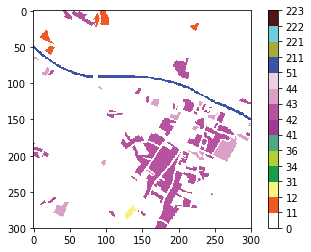

Training error: 0.113841
Generalization error: 0.775017
Training error: 0.113932
Generalization error: 0.834556
Training error: 0.001456
Generalization error: 0.586891


In [29]:
refdata=np.load("train1ref.npy")[0:300,0:300,0]  
displayMap(refdata)
trd, trt = imToLists(data_ndvi,refdata)
dt, dtTrainScore, dtGenScore = evalDT(trd,trt,ted,tet,5)
rf, rfTrainScore, rfGenScore = evalRF(trd,trt,ted,tet,100,5)
gtb, gtbTrainScore, gtbGenScore = evalXGB(trd,trt,ted,tet,100,5)

print("Training error: %g"%(1-dtTrainScore))
print("Generalization error: %g"%(1-dtGenScore))
print("Training error: %g"%(1-rfTrainScore))
print("Generalization error: %g"%(1-rfGenScore))
print("Training error: %g"%(1-gtbTrainScore))
print("Generalization error: %g"%(1-gtbGenScore))